<a href="https://colab.research.google.com/github/jung-han-lee/Projects/blob/master/Project_Sentiment_analysis_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Download datasets to Colab

In [ ]:
%matplotlib inline
#manipulation
import numpy as np
import pandas as pd

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
import string
import re
from nltk.corpus import stopwords

#stemming/lemmatizing/vectorizing
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

#processing
from sklearn.model_selection import train_test_split

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Check device type: To use tensorflow with big data, GPU is essential.


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12895683692560764689, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11453381397991793378
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8226485268698908859
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16384596572803536325
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jung1han1lee","key":"2989a4b8b1542d70845cd810ca3c9254"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle kernels list

ref                                                             title                                              author                lastRunTime          totalVotes  
--------------------------------------------------------------  -------------------------------------------------  --------------------  -------------------  ----------  
therealcyberlord/coronavirus-covid-19-visualization-prediction  Coronavirus (COVID-19) Visualization & Prediction  Xingyu Bian           2020-08-15 17:26:45         977  
allunia/don-t-turn-into-a-smoothie-after-the-shake-up           Don't turn into a Smoothie after the Shake-Up      Laura Fink            2020-08-15 20:36:28         269  
fedi1996/house-prices-data-cleaning-viz-and-modeling            House Prices : Data cleaning, viz and modeling     Fedi Ben Messaoud     2020-08-15 23:42:29         109  
roshansharma/immigration-to-canada                              Immigration to Canada                              Roshan Sharma         2020-08-

In [ ]:
!kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products

 31% 5.00M/16.3M [00:00<00:00, 15.9MB/s]
100% 16.3M/16.3M [00:00<00:00, 41.1MB/s]


In [ ]:
!ls

consumer-reviews-of-amazon-products.zip  kaggle.json  sample_data


In [ ]:
!unzip -q consumer-reviews-of-amazon-products.zip -d .

In [ ]:
!ls

1429_1.csv
consumer-reviews-of-amazon-products.zip
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
kaggle.json
sample_data


In [ ]:
import pandas as pd
data = pd.read_csv("1429_1.csv")

In [ ]:
data.shape

(34660, 21)

In [ ]:
data.head(3)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ


In [ ]:
data['label'] = [1 if star >= 4 else 0 for star in data['reviews.rating']];

In [ ]:
review = data[['reviews.rating', 'reviews.text','reviews.title','label']]
review.dropna(inplace=True)

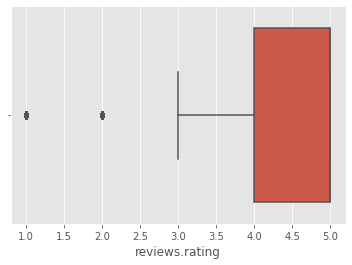

In [ ]:
sns.boxplot(review['reviews.rating'])

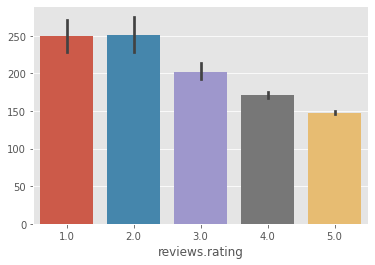

In [ ]:
length = [len(text) for text in review['reviews.text']]
sns.barplot(review['reviews.rating'],length)

In [ ]:
train = review[:int(len(review)/2)+1]
test = review[int(len(review)/2)+1:]
label_list = [0,1] #negative , positive

In [ ]:
review.head()

,reviews.rating,reviews.text,reviews.title,label
0,5.0,This product so far has not disappointed. My c...,Kindle,1
1,5.0,great for beginner or experienced person. Boug...,very fast,1
2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,1
3,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,1
4,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,1


# 1. RNN

## 1.1. Data Cleaning

In [ ]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)


In [ ]:
#apply to whole text column
review['reviews.text'] = review['reviews.text'].apply(expand_contractions)

In [ ]:
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras import Input

np.random.seed(34)
tf.random.set_seed(34)

to_exclude = '*+-/()%\n[\\]{|}^_`~\t'

tokenizer = Tokenizer(filters = to_exclude) # to include punctuation.
tokenizer.fit_on_texts(review['reviews.text'])
sequences = tokenizer.texts_to_sequences(review['reviews.text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', train['label'].shape)

X_train = data[:int(len(review)/2)+1]
y_train = train['label']
X_test = data[int(len(review)/2)+1:]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 14486 unique tokens.
Shape of data tensor: (34621, 1887)
Shape of label tensor: (17311,)


## 1.2. GloVe Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-08-07 12:20:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-07 12:20:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-07 12:20:31--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
#get GloVe vector embeddings
embeddings_index = {}
with open('glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

400000it [00:23, 17308.85it/s]


In [ ]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions

In [ ]:
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 14486/14486 [00:00<00:00, 439582.75it/s]


In [ ]:
print("Our embedded matrix is of dimension", embedding_matrix.shape)

Our embedded matrix is of dimension (14487, 200)


In [ ]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

## 1.3. LSTM Model

In [ ]:
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate):
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    emb = embedding(nlp_input)
    
    #add dropout and LSTM layer
    emb = SpatialDropout1D(rate = spatial_dropout)(emb) 
    nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_regularizer = regularizers.l2(1e-4),
                                 kernel_initializer = 'orthogonal')))(emb)
    
    #add meta data and output layer
    x = nlp_out
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile
    model = Model(inputs = nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [ ]:
#define initial dropout/learning rates
spatial_dropout = 0.2
dropout = 0.2
recurrent_dropout = 0.2
learning_rate = 0.01

model1 = create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate)
model1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nlp_input (InputLayer)       [(None, 1887)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1887, 200)         2897400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1887, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,138,401
Trainable params: 241,001
Non-trainable params: 2,897,400
______________________________________

In [ ]:
#fit model
history1 = model1.fit([X_train],y_train, validation_split = .2,epochs = 3, batch_size = 128,verbose = 1)

Epoch 1/3
109/109 [==============================] - 2109s 19s/step - loss: 0.3015 - accuracy: 0.9124 - val_loss: 0.2871 - val_accuracy: 0.9096
Epoch 2/3
109/109 [==============================] - 2136s 20s/step - loss: 0.2608 - accuracy: 0.9150 - val_loss: 0.2410 - val_accuracy: 0.9137
Epoch 3/3
109/109 [==============================] - 2112s 19s/step - loss: 0.2511 - accuracy: 0.9145 - val_loss: 0.2265 - val_accuracy: 0.9139


## 1.4. More complecate model : Adding Hidden Layer

In [ ]:
def create_lstm_complex(spatial_dropout, dropout, recurrent_dropout, learning_rate):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    # meta_input_train = Input(shape = (8, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
     
    #add meta data    
    x = nlp_out
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [ ]:
#define dropout rates
spatial_dropout = .4
dropout = .4
recurrent_dropout = .4
learning_rate = 0.01

#define new model
model2 = create_lstm_complex(spatial_dropout, dropout, recurrent_dropout, learning_rate)

In [ ]:
history2 = model2.fit([X_train], y_train, validation_split = .2,
         epochs = 2, batch_size = 128, verbose = 1) #callbacks = [callback]

Epoch 1/2
109/109 [==============================] - 2116s 19s/step - loss: 0.3168 - accuracy: 0.9109 - val_loss: 0.2948 - val_accuracy: 0.9096
Epoch 2/2
109/109 [==============================] - 2055s 19s/step - loss: 0.2765 - accuracy: 0.9154 - val_loss: 0.2632 - val_accuracy: 0.9096


## 1.5. GRU Model

In [ ]:
def create_gru(spatial_dropout, dropout, recurrent_dropout, learning_rate):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    nlp_out = (Bidirectional(GRU(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
     
    #add meta data    
    x = nlp_out
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [ ]:
#define dropout rates
spatial_dropout = .4
dropout = .4
recurrent_dropout = .4    
learning_rate = 0.01

#define new model
model3 = create_gru(spatial_dropout, dropout, recurrent_dropout, learning_rate)

In [ ]:
history3 = model3.fit([X_train], y_train, validation_split = .2,
         epochs = 2, batch_size = 128, verbose = 1) #callbacks = [callback]

Epoch 1/2
109/109 [==============================] - 2118s 19s/step - loss: 0.3132 - accuracy: 0.9132 - val_loss: 0.3871 - val_accuracy: 0.9096
Epoch 2/2
109/109 [==============================] - 2136s 20s/step - loss: 0.2812 - accuracy: 0.9154 - val_loss: 0.2574 - val_accuracy: 0.9096


# 2. Bert

In [ ]:
!pip install tensorflow-gpu==1.12.2
#!pip install tensorflow-gup==1.13.1
!pip install tensorflow-hub==0.04


!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [ ]:
OUTPUT_DIR = 'OUTPUT'
try:
  tf.gfile.DeleteRecursively(OUTPUT_DIR)
except:
  pass
tf.gfile.MakeDirs(OUTPUT_DIR)


In [ ]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 3.8MB/s 


In [ ]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

## 2.1. Data Preprocessing


In [ ]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['reviews.text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['reviews.text'], 
                                                                   text_b = None, 
                                                                   label = x['label']), axis = 1)

In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

#Create a tokenizer
def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

## 2.2. Model

In [ ]:
#matic calculation
def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer 
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [ ]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics.
      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [ ]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [ ]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9efd36c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'OUTPUT', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9efd36c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:00.015490


The BERT model has the highest accuracy!!!


In [ ]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-31-17:28:24


INFO:tensorflow:Starting evaluation at 2020-07-31-17:28:24


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from OUTPUT/model.ckpt-1622


INFO:tensorflow:Restoring parameters from OUTPUT/model.ckpt-1622


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-07-31-17:33:39


INFO:tensorflow:Finished evaluation at 2020-07-31-17:33:39


INFO:tensorflow:Saving dict for global step 1622: auc = 0.618464, eval_accuracy = 0.96019644, f1_score = 0.979453, false_negatives = 61.0, false_positives = 628.0, global_step = 1622, loss = 0.20460203, precision = 0.96316713, recall = 0.9962992, true_negatives = 199.0, true_positives = 16422.0


INFO:tensorflow:Saving dict for global step 1622: auc = 0.618464, eval_accuracy = 0.96019644, f1_score = 0.979453, false_negatives = 61.0, false_positives = 628.0, global_step = 1622, loss = 0.20460203, precision = 0.96316713, recall = 0.9962992, true_negatives = 199.0, true_positives = 16422.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1622: OUTPUT/model.ckpt-1622


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1622: OUTPUT/model.ckpt-1622


{'auc': 0.618464,
 'eval_accuracy': 0.96019644,
 'f1_score': 0.979453,
 'false_negatives': 61.0,
 'false_positives': 628.0,
 'global_step': 1622,
 'loss': 0.20460203,
 'precision': 0.96316713,
 'recall': 0.9962992,
 'true_negatives': 199.0,
 'true_positives': 16422.0}

# 3. New Section : Let's use the test data to see how the best model(BERT) works.

Now let's write code to make predictions on new sentences:

In [ ]:
def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
pred_sentences = [
  "it makes error everytime.",
  "Color is way too bright. I won't buy it again",
  "Too big to me. I recommend it to tall guys like 6.0",
  "Too big to me",
  "Not fully satisfied. So it's okay"
]

In [ ]:
predictions = getPrediction(pred_sentences)

In [ ]:
predictions

[('it makes error everytime.',
  array([-0.04375695, -3.1509042 ], dtype=float32),
  'Negative'),
 ("Color is way too bright. I won't buy it again",
  array([-0.01572119, -4.1605964 ], dtype=float32),
  'Negative'),
 ('Too big to me. I recommend it to tall guys like 6.0',
  array([-5.403069e+00, -4.512959e-03], dtype=float32),
  'Positive'),
 ('Too big to me',
  array([-2.7515728 , -0.06595545], dtype=float32),
  'Positive'),
 ("Not fully satisfied. So it's okay",
  array([-0.20968884, -1.6651435 ], dtype=float32),
  'Negative')]